In [1]:
import zerosum as zs

In [140]:
from typing import ClassVar, cast
from dataclasses import dataclass
import random


@dataclass(slots=True, frozen=True)
class Reserve:
    reserve: int


@dataclass(slots=True, frozen=True)
class Bid:
    bid: int


@dataclass(slots=True, frozen=True)
class Fold:
    ...


Action = Reserve | Bid | Fold


@dataclass(slots=True, frozen=True)
class InfoSet:
    player: zs.Player
    reserve: int

    theirs: tuple[int, ...]
    ours: tuple[int, ...]

    def actions(self) -> tuple[Action, ...]:
        last = 0
        if self.theirs:
            last = self.theirs[-1]

        return (Fold(),) + tuple(Bid(q) for q in range(1 + last, 1 + self.reserve))


@dataclass(slots=True, frozen=True)
class Ascending:
    players: ClassVar[int] = 2
    maxreserve: ClassVar[int] = 20
    cap: ClassVar[int] = 4

    history: tuple[Action, ...] = ()

    @classmethod
    def default(cls):
        return cls()

    @property
    def terminal(self):
        return (
            len(self.history) - 2 > self.cap
            or (bool(self.history) and isinstance(self.history[-1], Fold))
        )

    def payoff(self, player: zs.Player):
        if not isinstance(self.history[-1], Fold):
            return 0

        reserve = cast(Reserve, self.history[player]).reserve
        if len(self.history) == 3:
            return reserve if player == self.active else 0

        last = cast(Bid, self.history[-2]).bid
        winner = zs.Player(self.active)

        if winner == player:
            return reserve - last
        
        return 0

    @property
    def chance(self) -> bool:
        return len(self.history) < 2
    
    def chances(self):
        raise NotImplementedError
    
    def sample(self):
        return Reserve(random.randint(1, self.maxreserve))
    
    @property
    def active(self):
        return zs.Player(len(self.history) % 2)

    def infoset(self, player: zs.Player):
        reserve = cast(Reserve, self.history[player])

        theirs = tuple(cast(Bid, a).bid for a in self.history[2 + (1 - player)::2])
        ours = tuple(cast(Bid, a).bid for a in self.history[2 + player::2])

        return InfoSet(player, reserve.reserve, theirs, ours)
    
    def apply(self, action: Action):
        return self.__class__(self.history + (action,))

In [160]:
algo = zs.Algorithm(zs.ESLCFR(100), Ascending)

In [232]:
from tqdm import trange


try:
    for _ in trange(100000):
        algo.once()
except KeyboardInterrupt:
    pass

  3%|▎         | 2562/100000 [40:55<25:56:43,  1.04it/s]   


In [233]:
len(algo.impl.strategies)

42298

In [234]:
from zerosum.game import play

g = Ascending.default().apply(Reserve(10)).apply(Reserve(8))

list(play(g, algo.impl.strategies))

[Bid(bid=3), Bid(bid=5), Bid(bid=6), Bid(bid=7), Bid(bid=8)]

In [235]:
import numpy as np


strats = zs.normalize(algo.impl.strategies)

table = np.zeros((Ascending.maxreserve, Ascending.maxreserve))
for r in range(1, Ascending.maxreserve):
    iset = InfoSet(zs.Player(1), r, (5,), ())
    s = strats[iset]

    for act, p in s.items():
        if isinstance(act, Bid):
            table[r, act.bid] = p

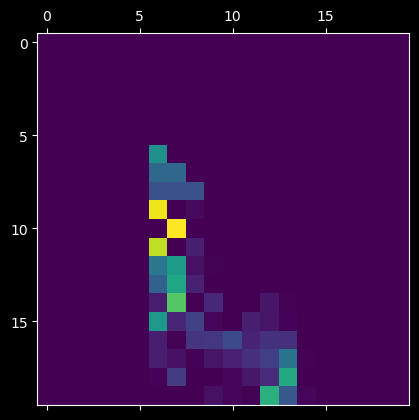

In [236]:
import matplotlib.pyplot as plt

plt.matshow(table)